# Deploying an Object DetectionModel

In this notebook, I will deploy a computer vision model trained to detect common objects in images. This notebook employs a pretrained object detection model called `YOLOV3`. This model is very convenient for two reasons: it runs really fast, and it yields accurate results.

Here, I will:
1. Inspect the image data set used for object detection
2. Take a look at the model itself
3. Deploy the model using FastAPI

## Part 1: Object Detection with YOLOV3

### Inspecting the images

In this section, I'll use 🔗[`YOLOV3`](https://pjreddie.com/darknet/yolo/) for an object detection task.

Let's take a look at the images that will be passed to the YOLOV3 model. Scanning the images will help to form an intuition about what types of objects will be detected. These images are part of the 🔗[`ImageNet`](http://www.image-net.org/index) dataset.

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


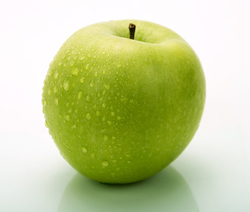


Displaying image: clock.jpg


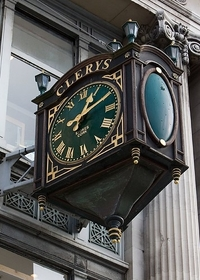


Displaying image: oranges.jpg


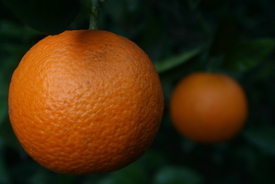


Displaying image: car.jpg


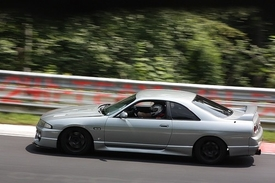

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model


Now, I will check how accurately the model can detect and classify them.

For this task, I will use 🔗[`cvlib`](https://github.com/arunponnusamy/cvlib), which is a very simple but powerful library for object detection that is fueled by 🔗[`OpenCV`](https://docs.opencv.org/4.5.1/) and 🔗[`Tensorflow`](https://www.tensorflow.org/).

I will use the 🔗[`detect_common_objects`](https://github.com/arunponnusamy/cvlib/tree/master/docs#object-detection) function from `cvlib`, which takes an image formatted as a 🔗[`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) and returns the code below.

- `bbox`: list of lists containing bounding box coordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```
    

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['orange', 'orange']
    ```


- `conf`: list of confidence scores for detected objects. A confidence score reflects the model's certainty that the object is really in the image.
        Example:
        
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```
    

Here's what a saved image with bounding boxes and labels might look like. 

![two oranges detected by YOLOV3](images/oranges_with_bbox.jpeg)

### Creating the detect_and_draw_box function

This function will allow users to interact with your model when it is deployed, called `detect_and_draw_box`. When a user needs to have the model detect objects in an image, FastAPI will use this function. 

First, I create a directory where I can store the resulting images:


In [3]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the `detect_and_draw_box` function which takes as input arguments: the **filename** of a file on your system, a **model**, and a **confidence level**. With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

This function receives the model as an input argument because you have options for which model to use. Going forward, you should use `yolov3-tiny`, a model designed for constrained environments. This model is less accurate than the full model, but still works pretty well. Downloading its pretrained weights takes less time.

Recall that the model's output is a vector of probabilities representing the model's confidence that a particular object is in the image at a particular location. The function will use its last input argument, confidence level, to determine the threshold that the probability needs to surpass to report that a given object is detected in the supplied image. By default, `detect_common_objects` uses a value of 0.5. That is, if the model is more than 50% confident in the location of an object in the image, it will draw the bounding box in the newly saved image.

In [4]:
import cv2

# suppress Tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717183351516724



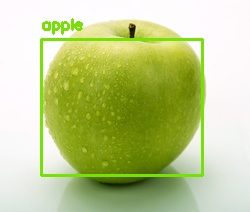

Image processed: clock.jpg

Detected object: clock with confidence level of 0.968317985534668



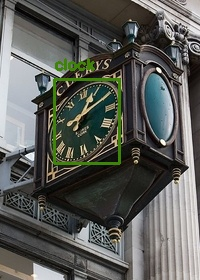

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185599565505981

Detected object: orange with confidence level of 0.5561732053756714



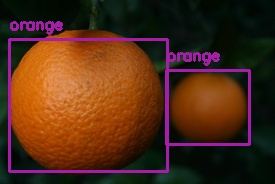

Image processed: car.jpg

Detected object: car with confidence level of 0.6325422525405884



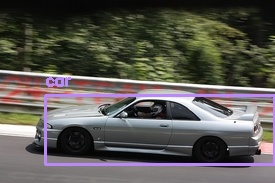

In [5]:
for image_file in image_files:
    detect_and_draw_box(image_file)

### Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818485617637634

Detected object: orange with confidence level of 0.5346476435661316

Detected object: orange with confidence level of 0.5150948166847229



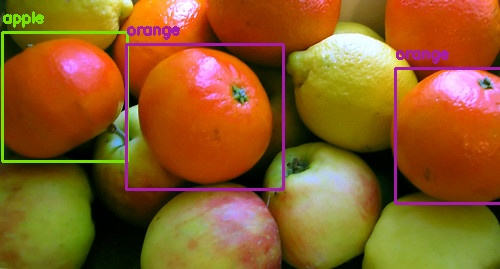

In [6]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before, so one might think the model has a fair representation on how an apple looks like.

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test if  this is a valid hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818485617637634

Detected object: orange with confidence level of 0.5346476435661316

Detected object: orange with confidence level of 0.5150948166847229

Detected object: apple with confidence level of 0.3476020395755768

Detected object: orange with confidence level of 0.32876279950141907

Detected object: apple with confidence level of 0.3124457597732544

Detected object: orange with confidence level of 0.27985894680023193

Detected object: orange with confidence level of 0.27499887347221375

Detected object: apple with confidence level of 0.2744504511356354

Detected object: orange with confidence level of 0.21419422328472137



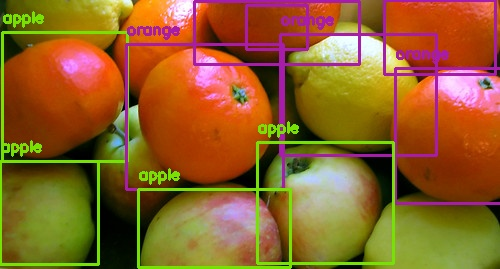

In [7]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level, the model successfully detected most of the fruits. However, it can be seen that some of them are misclassified (e.g. the label says "orange" but it's actually an apple or lemon). It is the case when the confidence level is really low. 
In general, it shows that you should be careful when altering parameters like this confidence level, as changing them might yield undesired results. Be mindful of the type of environment where you will be deploying your model: is a quick but inaccurate predication more desirable, or is accuracy more important?

As for this concrete example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

## Part 2: Deploying the model using FastAPI - Client-Server model

### Server

#### Placing the object detection model in a server

`FastAPI`. 🔗[Access for FastAPI docs here.](https://fastapi.tiangolo.com/) 

Now, I create a directory to store the images that are uploaded to the server.


In [8]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

#### Spinning up the server

Create the server using [FastAPI](https://fastapi.tiangolo.com/) and uvicorn.

In [9]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [10]:
# Assign an instance of the FastAPI class to the variable "app".
# I will interact with my api using this instance.
app = FastAPI(title='Deploying an Object Detection ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") I am allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Perfect! Fast API is working as expected."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell we will spin up the server! See the steps below for interacting with it!


In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!   
uvicorn.run(app, host=host, port=8000, root_path="/serve")

INFO:     Started server process [15960]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:58219 - "GET /serve/predict?model=yolov3-tiny HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:58227 - "GET /serve/predict?model=yolov3-tiny HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:58230 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58232 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58234 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58236 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58239 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58241 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58243 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58251 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58253 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:58255 - "POST /serve/predi

Head over to `http://127.0.0.1:8000/` to see it in action.